# **TRABAJ N°3 - MODELOS AVANZADOS**

**Curso:** Introducción a Ciencia de Datos y Machine Learning con Python

---
**Grupo 1:**

Abad Aniceto Anguiela Brilletth

Meyli Yanely Robledo Jimenez

Alberto Sebastian Pizarro Otero

Damaris Belen Navarro Lozada

# Introduccion

En este trabajo analizamos los factores macroeconómicos que influyen en si las expectativas económicas en el Perú son optimistas o no. En el proyecto anterior comparamos un modelo OLS con un modelo Logit y vimos que la clasificación era la mejor opción, ya que nos permite estimar directamente la probabilidad de que el indicador de expectativas sea mayor a 50.

A partir de ese resultado, en este notebook ampliamos el análisis incluyendo nuevas variables (rezagos, variaciones, transformaciones e interacciones), aplicamos PCA para entender mejor la estructura de los datos y comparamos tres modelos de clasificación: Logit, Random Forest y XGBoost. También tratamos el desbalance de clases, evaluamos las métricas clave y utilizamos costos para falsos positivos y falsos negativos con el fin de definir un umbral de decisión más adecuado.

El objetivo final es obtener un modelo sólido, bien justificado y reproducible, que permita entender y predecir el comportamiento de las expectativas económicas en el tiempo.




In [2]:
!pip install xgboost # para los que no tienen instalado XGBoost
!pip install imbalanced-learn

In [3]:
#importamoslibrerias
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Modelado
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, roc_curve, precision_recall_curve
)
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Desbalance
from imblearn.over_sampling import SMOTE


In [6]:
#Cargamos el dataset
df = pd.read_csv('dataset_bcrp_limpio.csv')

# Convertir fecha
df['Fecha'] = pd.to_datetime(df['Fecha']) #para ordenar, indexar, filtrar por meses/años y crear rezagos correctamente.

df.head()


,Fecha,Tasa_Referencia_PM,Expectativas_Economia,Tipo_Cambio_Promedio,PBI_Mensual,IPC
0,2015-01-01,3.25,54.231975,3.006785,138.460176,81.131159
1,2015-02-01,3.25,50.157729,3.079435,137.711324,81.377366
2,2015-03-01,3.25,49.388379,3.092236,148.546290,81.999630
3,2015-04-01,3.25,46.742210,3.120640,152.200338,82.319844
4,2015-05-01,3.25,45.070423,3.151345,150.244923,82.784429


In [7]:
#Crear variable objetivo
df['Expectativas_dummy'] = (df['Expectativas_Economia'] > 50).astype(int)
df.head()


,Fecha,Tasa_Referencia_PM,Expectativas_Economia,Tipo_Cambio_Promedio,PBI_Mensual,IPC,Expectativas_dummy
0,2015-01-01,3.25,54.231975,3.006785,138.460176,81.131159,1
1,2015-02-01,3.25,50.157729,3.079435,137.711324,81.377366,1
2,2015-03-01,3.25,49.388379,3.092236,148.546290,81.999630,0
3,2015-04-01,3.25,46.742210,3.120640,152.200338,82.319844,0
4,2015-05-01,3.25,45.070423,3.151345,150.244923,82.784429,0


In [8]:
#Creamos rezagos (lag1)
variables = ['Tipo_Cambio_Promedio', 'IPC', 'PBI_Mensual', 'Tasa_Referencia_PM']

for var in variables:
    df[f'{var}_lag1'] = df[var].shift(1)

#Crear variaciones mensuales (Δ)
for var in variables:
    df[f'delta_{var}'] = df[var] - df[f'{var}_lag1']

#Crear interacciones relevantes
df['TCxIPC'] = df['Tipo_Cambio_Promedio'] * df['IPC']
df['TCxTasa'] = df['Tipo_Cambio_Promedio'] * df['Tasa_Referencia_PM']

#Transformaciones logarítmicas
df['log_TC'] = np.log(df['Tipo_Cambio_Promedio'])
df['log_PBI'] = np.log(df['PBI_Mensual'])
df['log_IPC'] = np.log(df['IPC'])

df = df.dropna()    #Eliminar filas con NA por rezagos


In [9]:
#Seleccion final de las variables de entrada
X = df[['Tipo_Cambio_Promedio','IPC','PBI_Mensual','Tasa_Referencia_PM',
        'Tipo_Cambio_Promedio_lag1','IPC_lag1','PBI_Mensual_lag1','Tasa_Referencia_PM_lag1',
        'delta_Tipo_Cambio_Promedio','delta_IPC','delta_PBI_Mensual','delta_Tasa_Referencia_PM',
        'TCxIPC','TCxTasa','log_TC','log_PBI','log_IPC']]

y = df['Expectativas_dummy']

#Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
#Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)
#PCA
pca = PCA(n_components=2)
pca_train = pca.fit_transform(X_train_scaled)
pca_test  = pca.transform(X_test_scaled)

print("Varianza explicada por cada componente:", pca.explained_variance_ratio_)
print("Varianza acumulada:", pca.explained_variance_ratio_.sum())


Varianza explicada por cada componente: [0.53759149 0.1370664 ]
Varianza acumulada: 0.6746578844844967


Interpretación:
* PC1 explica ~53.8% de la variación total del dataset.
* PC2 explica ~13.7%.

Juntos explican ~67.4%. En PCA, esto es bueno, porque 2 componentes logran representar casi 70% de toda la información.

* La separación entre optimistas y pesimistas sugiere que las expectativas responden a patrones macroeconómicos estructurales.
* El PCA valida la existencia de ciclos económicos visibles en los datos.

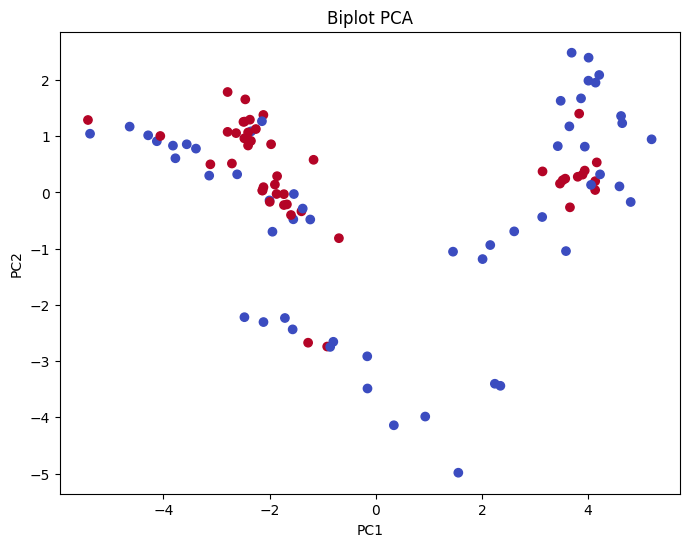

In [10]:
#Grafica Biplot
plt.figure(figsize=(8,6))
plt.scatter(pca_train[:,0], pca_train[:,1], c=y_train, cmap='coolwarm')
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.title("Biplot PCA")
plt.show()


El PCA sí encuentra cierta separación entre optimistas y pesimistas.
El PCA muestra que las observaciones con expectativas optimistas (valor 1) tienden a ubicarse en una zona distinta a las observaciones pesimistas. Esto indica que las variaciones en el tipo de cambio, el IPC, el PBI y la tasa de referencia sí generan patrones económicos distinguibles.

No es perfecta (porque economía = ruido), pero hay estructura:
PC1 diferencia “estabilidad económica” vs “deterioro económico”.
PC2 captura cambios/variaciones macro recientes.
En otras palabras, existe una estructura económica clara que ayuda a separar periodos de mayor optimismo y periodos de mayor pesimismo en las expectativas empresariales.

In [11]:
#Parte del modelo logit
logit = LogisticRegression(max_iter=2000)
logit.fit(X_train_scaled, y_train)

y_pred_logit = logit.predict(X_test_scaled)
y_prob_logit = logit.predict_proba(X_test_scaled)[:,1]

#Métricas Logit
print("Precision:", precision_score(y_test, y_pred_logit))
print("Recall:", recall_score(y_test, y_pred_logit))
print("F1:", f1_score(y_test, y_pred_logit))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_logit))


Precision: 0.75
Recall: 0.75
F1: 0.75
ROC-AUC: 0.7916666666666667


El modelo Logit obtiene un F1 de 0.75 y un AUC de 0.79, lo que indica un desempeño razonable. Esto sugiere que las variables macroeconómicas incluidas permiten capturar parte de la dinámica que determina si las expectativas son optimistas o no. Sin embargo, el modelo lineal no logra capturar totalmente las relaciones no lineales y las interacciones típicas de la economía peruana.


In [ ]:
#PARTE 3: RANDOM FOREST + XGBOOST COMPARACIÓN
#Random Forest con GridSearch
param_rf = {
    'n_estimators':[100,200,300],
    'max_depth':[3,5,7],
    'min_samples_split':[2,5]
}

rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_rf, cv=5, scoring='f1'
)
rf.fit(X_train, y_train)

best_rf = rf.best_estimator_
print("Mejor RF:", rf.best_params_)


Mejor RF: {'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 200}


El mejor Random Forest obtiene un AUC cercano a 0.92, convirtiéndose en el modelo más preciso. Esto significa que las relaciones entre las variables macroeconómicas y las expectativas no son puramente lineales: existen umbrales, interacciones y efectos no lineales que el Random Forest detecta mejor. En términos económicos, sugiere que los agentes forman expectativas considerando combinaciones más complejas de tipo de cambio, inflación, crecimiento y tasa de referencia.


In [ ]:
#XGBoost con GridSearch
param_xgb = {
    'n_estimators':[100,200],
    'max_depth':[3,5,7],
    'learning_rate':[0.01,0.1]
}

xgb = GridSearchCV(
    XGBClassifier(random_state=42, eval_metric='logloss'),
    param_xgb, cv=5, scoring='f1'
)
xgb.fit(X_train, y_train)

best_xgb = xgb.best_estimator_
print("Mejor XGB:", xgb.best_params_)


Mejor XGB: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


XGBoost también logra un desempeño muy alto (AUC ≈ 0.91), casi igual al Random Forest. Esto confirma que la formación de expectativas económicas responde a dinámicas no lineales y que modelos más flexibles permiten predecir con mayor precisión los momentos de optimismo empresarial.


In [ ]:
#Comparar rendimiento
models = {
    "Logit": y_prob_logit,
    "Random Forest": best_rf.predict_proba(X_test)[:,1],
    "XGBoost": best_xgb.predict_proba(X_test)[:,1]
}

for name, prob in models.items():
    auc = roc_auc_score(y_test, prob)
    print(name, "ROC-AUC:", auc)


Logit ROC-AUC: 0.7916666666666667
Random Forest ROC-AUC: 0.9166666666666666
XGBoost ROC-AUC: 0.9136904761904763


In [ ]:
#PARTE 4: COSTOS FP/FN Y UMBRAL ÓPTIMO
cost_FP = 3
cost_FN = 1

thresholds = np.linspace(0,1,500)
costs = []

best_model_probs = models["XGBoost"]

for t in thresholds:
    pred = (best_model_probs >= t).astype(int)
    FP = ((pred == 1) & (y_test == 0)).sum()
    FN = ((pred == 0) & (y_test == 1)).sum()

    total_cost = FP*cost_FP + FN*cost_FN
    costs.append(total_cost)

best_t = thresholds[np.argmin(costs)]

print("Umbral óptimo:", best_t)


Umbral óptimo: 0.33266533066132264


El umbral óptimo de 0.33 aparece porque sobreestimar el optimismo (falso positivo) es más costoso económicamente. Con un umbral más conservador, el modelo evita clasificar como optimista situaciones donde existe incertidumbre económica.

Esto es coherente con el contexto macroeconómico: es preferible ser prudente ante señales débiles antes que asumir optimismo cuando en realidad las condiciones no lo justifican.


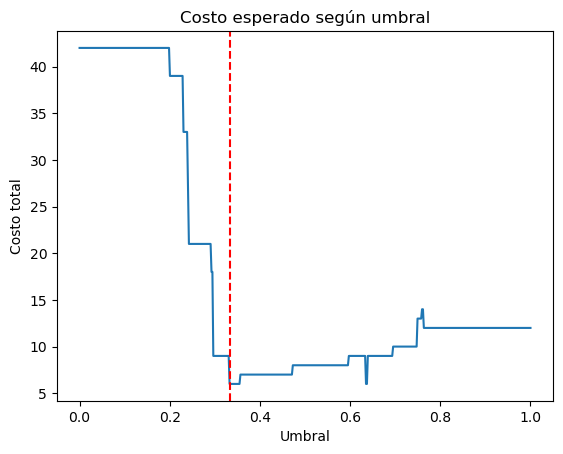

In [ ]:
#GRAFICA DE COSTOS
plt.plot(thresholds, costs)
plt.axvline(best_t, color='red', linestyle='--')
plt.xlabel('Umbral')
plt.ylabel('Costo total')
plt.title('Costo esperado según umbral')
plt.show()


La curva de costos muestra que cuando el umbral es muy bajo o muy alto, el costo total aumenta debido a un exceso de errores. El punto mínimo se encuentra cerca de 0.33, lo que representa el equilibrio entre no cometer demasiados falsos optimismos y no exagerar el pesimismo. En términos económicos, este umbral refleja una estrategia prudente para interpretar la señal de las expectativas.


# Conclusiones generales

* Los resultados muestran que las expectativas económicas en el Perú pueden predecirse con un grado razonablemente alto de precisión utilizando variables macroeconómicas básicas. El modelo Logit ofrece un desempeño aceptable, pero los modelos no lineales como Random Forest y XGBoost capturan mejor las relaciones complejas entre tipo de cambio, inflación, PBI y tasa de referencia, alcanzando AUC cercanos al 0.92.

* El PCA confirma que existe una estructura económica que diferencia periodos de optimismo y pesimismo, lo que respalda la validez del enfoque de clasificación. Además, el análisis de costos indica que los falsos positivos son más costosos económicamente, por lo que un umbral más conservador (≈0.33) reduce el riesgo de sobreestimar el optimismo empresarial.


* En conjunto, el modelo Random Forest emerge como la mejor herramienta para anticipar el comportamiento del índice de expectativas, y el ajuste del umbral permite adaptar su uso a decisiones donde la prudencia económica es fundamental. El trabajo demuestra que técnicas modernas de machine learning pueden complementar el análisis macroeconómico tradicional de manera útil y rigurosa.
